### Construct sequences of curves

In [2]:
##imports
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist, pdist
from scipy.stats import pearsonr
from scipy.special import comb
from scipy.linalg import block_diag

from sklearn.decomposition import PCA
from sklearn.metrics import auc


import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

from itertools import combinations_with_replacement

%config Completer.use_jedi = False
%matplotlib inline

# from math import factorial
# import random
# import sys
# from tqdm.notebook import tqdm as log_progress

##torch stuff
# import torch
# from torch import nn
# from torchvision import datasets
# from torch.utils.data import TensorDataset, DataLoader, random_split
# from torch.utils.data._utils.collate import default_collate
# from torchvision.transforms import ToTensor
# from torch import sigmoid as sig
# from torch import relu
# from torch.nn.functional import smooth_l1_loss as smooth_l1
# from torch.nn.functional import leaky_relu
# Disable jedi autocompleter


# ##need to find this module, wherever you are
# #sys.path.append('/home/tnaselar/cmrr/Python/sweep_intersector/') ##nana
# sys.path.append('/home/range6-raid5/from-orochi4/orochi4-raid1/tnaselar/code/Python/sweep_intersector') ##hypatia
# from SweepIntersectorLib.SweepIntersector import SweepIntersector

In [3]:
##utilities for generating curves
##convert an N x 2 matrix of 2d points into an 2N array (x1,x2,...,xN,y1,y2,...,yN)
def xy2stacked(xy):
    n = xy.shape[0]
    return xy.reshape((n*2,1), order='F')

def stacked2xy(stacked):
    assert len(stacked) % 2 == 0
    n = int(len(stacked)/2)
    return stacked.reshape((n,2), order='F')

##converted "stacked" array into a N-1 x 4 matrix of stacked line segments, where each row is (x1,x2,y1,y2)
def stacked2segmented(curve):
    n_points = int(curve.shape[0]/2)
    assert n_points % 1 == 0
    x1_idx = np.arange(0, n_points-1, dtype=int)
    x2_idx = np.arange(1, n_points, dtype=int)
    y1_idx = x1_idx + n_points
    y2_idx = x2_idx + n_points
    return np.stack([curve[x1_idx],curve[x2_idx],curve[y1_idx],curve[y2_idx]], axis = 1)

def linear_probe_set(lim, num, center = np.zeros(2), dash = False):
    cnt = 0
    base_probes = 6*num
    if dash is not False:
        num_probes=base_probes*(1+dash)
    else:
        num_probes = base_probes
    probes_nxy = np.zeros((num_probes, 2, 2)) ##
    print(f'making {num_probes} probes')
    eps = 0.01 ##avoid corners
    ##vertical probes
    for x in np.linspace(-lim+eps, lim-eps, num=num):
        probes_nxy[cnt, :,:] = np.array([[x,lim], [x,-lim]])
        cnt +=1
    ##horizontal probes
    for y in np.linspace(-lim+eps, lim-eps, num=num):
        probes_nxy[cnt, :,:] = np.array([[lim, y], [-lim, y]])
        cnt +=1
    ##negative oblique
    for y in np.linspace(-lim+eps, lim-eps, num=num):
        probes_nxy[cnt, :, :] = np.array([[-lim, y], [y, -lim]])
        cnt +=1
    for x in np.linspace(-lim+eps, lim-eps, num=num):
        probes_nxy[cnt, :, :] = np.array([[x, lim], [lim, x]])
        cnt +=1
    ##positive oblique
    for y in np.linspace(-lim+eps, lim-eps, num=num):
        probes_nxy[cnt, :, :] = np.array([[lim, y], [-y, -lim]])
        cnt +=1
    for x in np.linspace(-lim+eps, lim-eps, num=num):
        probes_nxy[cnt, :, :] = np.array([[x, lim], [-lim, -x]])
        cnt +=1
    if dash is not False:
        inc = 1./dash
        for i in range(base_probes):
            xp, yp = np.polyfit([0.,1.], probes_nxy[i][:,0],1),np.polyfit([0.,1.], probes_nxy[i][:,1],1)
            stop = 0
            for j in range(dash):
                start = stop
                stop = start+inc 
                probes_nxy[cnt][:,0] = np.polyval(xp,[start,stop])
                probes_nxy[cnt][:,1] = np.polyval(yp,[start,stop])
                cnt +=1
    probes_nxy += center
    return probes_nxy

def make_knot_grid(size, low, high):
    X,Y = np.meshgrid(np.linspace(low, high, num=size),np.linspace(low, high, num=size))
    grid = np.zeros((size**2, 2))
    grid[:,0] = X.ravel()
    grid[:,1] = Y.ravel()
    return grid ##xy format
    
def sample_knots(knot_grid, number_of_knot_points = False, closed = True):
    grid_size = knot_grid.shape[0]
    if not number_of_knot_points:
        nkp = knot_grid.shape[0]
    else:
        nkp = number_of_knot_points
        
    dice = np.random.choice(range(grid_size), nkp,replace=nkp > grid_size)
    if closed:
        dice[-1] = dice[0]
    return knot_grid[dice,:] ##xy format

# # ##a function for upsampling curves
##knots are 2d points in xy format
def upsample(knots, resolution = 1000, kind='quadratic'):  
    
    num_knots = knots.shape[0]
    
    if num_knots < 3:
        kind = 'linear'
    plot_range = np.linspace(0,num_knots-1, num = resolution)
    fx = interp1d(range(num_knots), knots[:,0], kind=kind)
    fy = interp1d(range(num_knots), knots[:,1], kind=kind)
    
    xy = np.zeros((len(plot_range),2))
    xy[:,0] = fx(plot_range)
    xy[:,1] = fy(plot_range)
    return xy, knots ##xy format for both the knot points and the interpolated points 

In [7]:
size_of_knot_grid = 10
low  = -1
high = 1
knot_grid = make_knot_grid(size_of_knot_grid, low, high)
max_knot_number = 10

D = 256 #"resolution_of_curves"
K = 2 ##number of axes in curve space that we will sample
S = 1 ##number of "exposures" to generate
N = 12 ##number of samples per exposure


##specify the "curve of origin"
curve_of_origin = np.zeros((D,2))
endcurve = np.zeros((D,2))
endcurve = np.zeros((D,2))


## ----circle
rng = np.array(range(D))/D*2.*np.pi
curve_of_origin[:, 0] = np.sin(rng)
curve_of_origin[:, 1] = np.cos(rng)
radius = 0.1*(high-low)
curve_of_origin *= radius
oXY = xy2stacked(curve_of_origin)

## -----random simple shape
# knots = sample_knots(knot_grid, 2,closed=False)
# curve_of_origin, _ = upsample(knots,D, kind = 'quadratic')  
# oXY = xy2stacked(curve_of_origin).T

##endcurves
n_knot_points = 5
knots = sample_knots(knot_grid,n_knot_points,closed=False)
endcurve, _ = upsample(knots,D, kind = 'quadratic')
el = np.sum(endcurve*endcurve)

knots = sample_knots(knot_grid,n_knot_points,closed=False)
other_curve, _ = upsample(knots,D, kind = 'quadratic')
orthocurve = np.sum(other_curve*endcurve)*endcurve/el - other_curve

print(f'check: {np.sum(orthocurve*endcurve):.2f}')

check: -0.00


In [8]:
##let's generate one sequence and look at it
scale_lim = 1

##travel smoothly along manfiold, sample a curve at each point
smooth_sequence = np.zeros((N,D, 2))
for i,t in enumerate(np.linspace(-scale_lim,scale_lim, N)):
        smooth_sequence[i,:,:] = curve_of_origin+t*endcurve

##random samples of curves along an orthogonal manifold: this is the "noise"
rough_sequence = np.zeros((N,D,2))
for n,t in enumerate(np.random.randn(N).clip(-scale_lim,scale_lim)):
    rough_sequence[n,:,:] = curve_of_origin+t*orthocurve

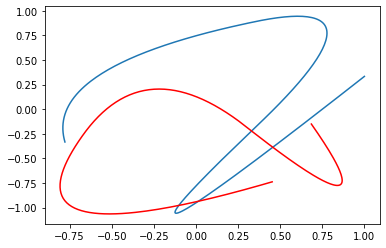

In [9]:

##the extremal curve on the manifold
plt.plot(endcurve[:,0], endcurve[:,1])

##a curve from the orthogonal manifold, i.e., a "noise" element
plt.plot(orthocurve[:,0], orthocurve[:,1], 'r')


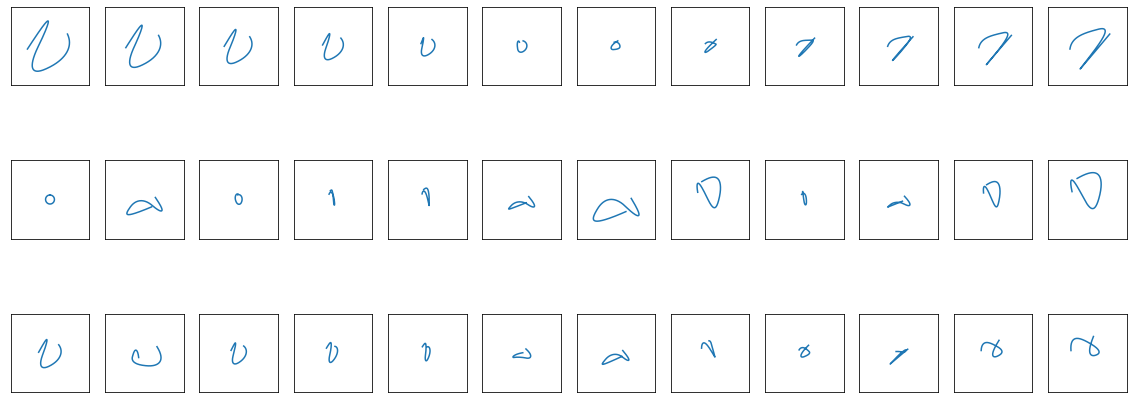

In [10]:
##plot sequences

lim = 1.75
limx = (-lim, lim)
limy = (-lim, lim)

fig, ax = plt.subplots(3,N, figsize = (20,8))

i = 0
##the smooth sequence
for n in range(N):
    ax[i,n].plot(smooth_sequence[n,:,0],smooth_sequence[n,:,1])
    ax[i,n].set_xlim(*limx)
    ax[i,n].set_ylim(*limy)
    ax[i,n].set_xticks([])
    ax[i,n].set_yticks([])
    ax[i,n].set_aspect('equal')

i = 1
##the random sequence
for n in range(N):
    ax[i,n].plot(rough_sequence[n,:,0],rough_sequence[n,:,1])
    ax[i,n].set_xlim(*limx)
    ax[i,n].set_ylim(*limy)
    ax[i,n].set_xticks([])
    ax[i,n].set_yticks([])
    ax[i,n].set_aspect('equal')
    
i = 2
##what the subject will see: the sum of the smooth sequence + noise
for n in range(N):
    ax[i,n].plot((rough_sequence+smooth_sequence)[n,:,0]/2.,(rough_sequence+smooth_sequence)[n,:,1]/2.)
    ax[i,n].set_xlim(*limx)
    ax[i,n].set_ylim(*limy)
    ax[i,n].set_xticks([])
    ax[i,n].set_yticks([])
    ax[i,n].set_aspect('equal')
    

In [ ]:
##generate many episodes by varying the smooth sequence in along a random interval / direction
##for each episode and each axis, determine if the final curve is to the "left" or "right" of the origin on each axis
##at experiment time, we can test to see how/if subjects can learn this, and how important temporal smoothness is